## Direct prompting experimence

### Dataset

In [114]:
import pandas as pd
from mymodule import read_bin,save_bin
df = read_bin("new_data_2/dfs_AB.bin")
df = df["PolitiFact"]

specific_date = '2023-11-01'  ## GPT-4o（gpt-4o-2024-08-06）以降:13084
df_A = df[df['itemReviewed.datePublished'] != -999]
df_A = df_A[df_A['itemReviewed.datePublished'] >= pd.to_datetime(specific_date,utc=True)]#after:1410

df_B = df[df['datePublished'] != -999]
df_B = df_B[df_B['datePublished'] < pd.to_datetime(specific_date,utc=True)]#before:405

df_A = df_A.sample(n=400)
df_B = df_B.sample(n=400)

In [115]:
def count_by_categories(df, cols):
    if isinstance(cols, list):
        return df.groupby(cols).size().reset_index(name='count')
    if isinstance(cols, str):
        return df[cols].value_counts().reset_index()

In [116]:
count_by_categories(df_A,["reviewRating.ratingValue","reviewRating.alternateName"])

,reviewRating.ratingValue,reviewRating.alternateName,count
0,0,True,16
1,1,Mostly True,16
2,2,Half True,26
3,3,Mostly False,28
4,4,False,255
5,5,Pants on Fire,59


In [117]:
count_by_categories(df_B,["reviewRating.ratingValue","reviewRating.alternateName"])

,reviewRating.ratingValue,reviewRating.alternateName,count
0,0,True,9
1,1,Mostly True,14
2,2,Half True,27
3,3,Mostly False,33
4,4,False,267
5,5,Pants on Fire,50


### GPT 4o setup

In [118]:
import configparser
config = configparser.ConfigParser()
config.read('config.ini')

from openai import OpenAI
client = OpenAI(api_key=config['openai']['api_key_mil'])

In [120]:
import time
from requests.exceptions import RequestException
from openai import OpenAI

def Prompt(claim):
    labels = ['False', 'Pants on Fire', 'Mostly False', 'Half True', 'Mostly True', 'True']
    few_shot = f"""Among {labels}, the claim ”’Emerson Moser, who was Crayola’s top crayon molder for almost 40 years, was colorblind.”’ can be classified as true.
Among {labels}, the claim ”’Bernie Sanders said 85 million Americans have no health insurance.”’ can be classified as half-true.
Among {labels}, the claim ”’Cheri Beasley “backs tax hikes — even on families making under $75,000.”’ can be classified as False.
 """
    return f"""{few_shot} Among {labels}, the claim ”’{claim}”’ can be classified as"""

def gpt4o_ans(prompt):
    stream = client.chat.completions.create(
        model="gpt-4o-2024-08-06",
        # model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        stream=True,
    )
    ans = []
    for chunk in stream:
        if chunk.choices[0].delta.content is not None:
            ans.append(chunk.choices[0].delta.content)
            
    return "".join(ans)
    

def validate_claim_via_pi(claim):
    prompt = Prompt(claim)
    for i in range(3):  # 3回までリトライ
        try:
            return gpt4o_ans(prompt)
            
        except openai.OpenAIError as e:
            time.sleep(5)
            if i == 2:
                return ""
                
        except RequestException as e:
            time.sleep(5)
            if i == 2:
                return ""

In [105]:
# from openai import OpenAI

# completion = client.completions.create(model='gpt-4o-2024-08-06',prompt=prompt)
# print(completion.choices[0].text)
# print(dict(completion).get('usage'))
# print(completion.model_dump_json(indent=2))

### experience

In [124]:
space = "                                                                                                                                                                                                                                                            "

In [88]:
# ans_dict_a = dict()

In [124]:
ids = list(df_A["id"])
gold_labels = list(df_A["reviewRating.alternateName"])
claims = list(df_A["claimReviewed"])

In [ ]:
for i in range(400):
    if ids[i] not in ans_dict_a:
        ans = validate_claim_via_pi(claims[i])
        ans_dict_a[ids[i]] = {"id":ids[i],"ans":ans,"label":gold_labels[i]}
        print("\r%d / %d  ans:%s %s %s" %(i,400,ans,space,space), end='')

In [132]:
# save_bin("new_data_2/df_A-ans_dict.bin",ans_dict_a)

In [121]:
ans_dict_b = dict()

In [122]:
ids = list(df_B["id"])
gold_labels = list(df_B["reviewRating.alternateName"])
claims = list(df_B["claimReviewed"])

In [ ]:
for i in range(400):
    if ids[i] not in ans_dict_b:
        ans = validate_claim_via_pi(claims[i])
        ans_dict_b[ids[i]] = {"id":ids[i],"ans":ans,"label":gold_labels[i]}
        print("\r%d / %d  ans:%s %s %s" %(i,400,ans,space,space), end='')

In [126]:
# save_bin("new_data_2/df_B-ans_dict.bin",ans_dict_b)

### 集計

In [364]:
from mymodule import read_bin,save_bin
df_A = read_bin("new_data_2/df_A-ans_dict.bin")
df_B = read_bin("new_data_2/df_B-ans_dict.bin")

In [366]:
len(df_B.)

400

In [ ]:
df_A.keys()
df_B.keys()

In [355]:
def labeled(df):
    for k,v in df.items():
        v["ans"] = v["ans"].replace("  ","_").replace("_"," ")
        
    for k,v in df.items():
        v["F"] = 0
        v["MF"] = 0
        v["POF"] = 0
        v["HT"] = 0
        v["MT"] = 0
        v["T"] = 0
        v["UnKnown"] = 0
        
        if "False" in v["ans"]:
            v["F"] = 1
            
        if "Mostly False" in v["ans"] and "False" in v["ans"]:
            v["F"] = 0
            v["MF"] = 1
                
        if "True" in v["ans"]:
            v["T"] = 0
            
        if "Mostly True" in v["ans"] and "True" in v["ans"]:
            v["T"] = 0
            v["MT"] = 1
        if "Half True" in v["ans"] and "True" in v["ans"]:
            v["T"] = 0
            v["HT"] = 1
            
        if "Pants on Fire" in v["ans"] or "P ants on Fire" in v["ans"]:
            v["POF"] = 1
    
        if v["F"]+v["MF"]+v["POF"]+v["HT"]+v["MT"]+v["T"] != 1:
            v["UnKnown"] = 1
    
    del_list = []
    for k,v in df.items():
        if v["UnKnown"] == 1:
            del_list.append(k)
            
    for k in del_list:
        df.pop(k, None)
    
    labels = [
        ('Pants on Fire', 'POF', 0),
        ('False', 'F', 1),
        ('Mostly False', 'MF', 2),
        ('Half True', 'HT', 3),
        ('Mostly True', 'MT', 4),
        ('True', 'T', 5)
    ]
    
    for k,v in df.items():
        v["pred_grad"] = None
        v["pred"] = None
        v["ans_grad"] = None
        for label,mini_label,level in labels:
            if v[mini_label] == 1:
                v["pred"] = label
                v["pred_grad"] = level
            if v["label"] == label:
                v["ans_grad"] = level
    return df

In [275]:
# for k,v in df.items():
#         print(v)
#         v["F"]=int(input("F"))
#         v["MF"]=int(input("MF"))
#         v["POF"]=int(input("POF"))
#         v["HT"]=int(input("HT"))
#         v["MT"]=int(input("MT"))
#         v["T"]=int(input("T"))

In [356]:
data_list_A = [v for v in labeled(df_A).values()]
data_list_B = [v for v in labeled(df_B).values()]

In [350]:
print(len(data_list_A),len(data_list_B))

380 375


In [351]:
# true_labels

In [363]:
data_list_A[0]

{'id': 'db48cb10-0531-4d12-84c7-042c79378022',
 'ans': ' "P ants on Fire ." There is no verified or credible evidence to support the claim that Russian President Vladimir Putin made such a statement in an interview with Tucker Carlson . This classification suggests that the claim is not only false but also absurd or ridiculous .',
 'label': 'False',
 'F': 0,
 'MF': 0,
 'POF': 1,
 'HT': 0,
 'MT': 0,
 'T': 0,
 'UnKnown': 0,
 'pred_grad': 0,
 'pred': 'Pants on Fire',
 'ans_grad': 1}

In [360]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, mean_absolute_error, f1_score

def AC_MAE_Matrix(data_list):
    true_labels = [v["ans_grad"] for v in data_list]
    pred_labels = [v["pred_grad"] for v in data_list]
    # label_names = ['Pants on Fire','False','Mostly False','Half True','Mostly True','True']
    
    accuracy = np.mean(np.array(true_labels) == np.array(pred_labels))
    print(f"Accuracy: {accuracy:.2f}")
    
    weighted_f1 = f1_score(true_labels, pred_labels, average='weighted')
    print(f"Weighted F1 Score: {weighted_f1:.2f}")
    
    mae = mean_absolute_error(true_labels, pred_labels)
    print(f"Mean Absolute Error: {mae:.2f}")
    
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    # xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

Accuracy: 0.32
Weighted F1 Score: 0.32
Mean Absolute Error: 0.85
Accuracy: 0.36
Weighted F1 Score: 0.35
Mean Absolute Error: 0.74


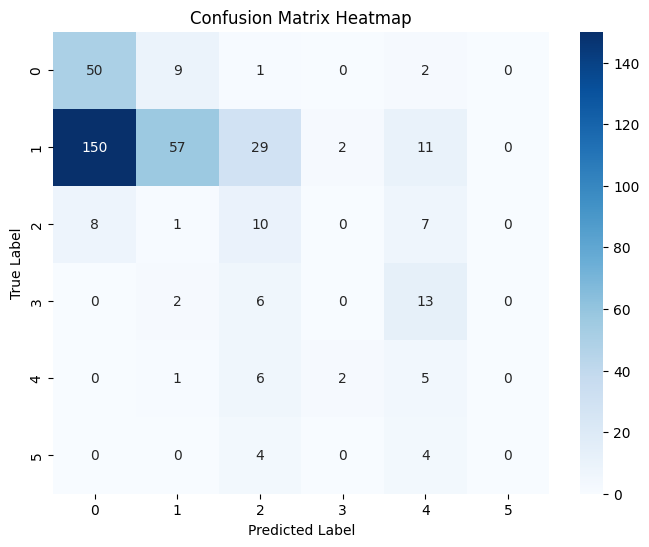

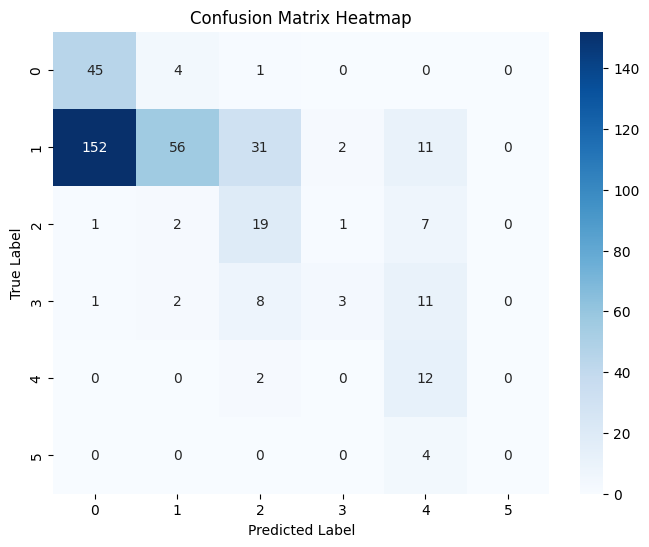

In [361]:
AC_MAE_Matrix(data_list_A)
AC_MAE_Matrix(data_list_B)

In [327]:
# df_A